In [1]:
# from math import ceil
from spatial_scan import scan, deploy
from vae import VAE, encoder, decoder, tf, keras
import vae as vaelib
import numpy as np
import matplotlib.pyplot as plt


2023-05-22 12:14:36.449978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 12:14:37.190656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-22 12:14:37.190715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-22 12:14:37.190722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
batch_len = 1000
lmax=0.5

with open("../mc-sampling/good-runs/test_30_5_0.05_0.3_0.1_10000_1000_1000_x.txt") as f:
    data = [[float(i.strip()) for i in s.split(" ") if i!=""] for s in f.read().split("\n") if s!=""]
    xyz=[[[data[h][i+3*j]for i in range(3)]for j in range(len(data[h])//3)]for h in range(len(data))]
    del data

# print(len(data), [len(data[i]) for i in range(len(data))])
model_checkpoint_callback = keras.callbacks.ModelCheckpoint("./checkpoints/", save_best_only=True)

def change_l(e,log):
    #global vae.l, lmax
    global lmax
    vaelib.l=(1-1/(2+e))*lmax
    print("l: ", vaelib.l)

regularization_callback = keras.callbacks.LambdaCallback(on_epoch_begin=change_l)
    

In [3]:
if False:#len(argv)>2 and argv[2]=="--resume":
    encoder=keras.models.load_model("./model-info/enc")
    decoder=keras.models.load_model("./model-info/dec")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [4]:
for i in range(1):#(ceil(len(xyz)/batch_len)):
    bdata = [] # will hold bucketed data version
    for j in range(batch_len*i, batch_len*(i+1)):
        if j>len(xyz):
            break
        #print(xyz[j])
        bdata.append([scan(xyz[j],5,5,5)])
    dataset = tf.data.Dataset.from_tensor_slices((bdata,))
    print("i: ",i)
    vae.fit(dataset, epochs=5, batch_size=128, callbacks=[model_checkpoint_callback, regularization_callback], verbose=1)

2023-05-22 12:15:10.112607: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.
2023-05-22 12:15:20.443147: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.


i:  0
l:  0.25
Epoch 1/5
1000/1000 [==============================] - 125s 123ms/step - loss: 0.0324 - reconstruction_loss: 0.0242 - kl_loss: 0.0091
l:  0.33333333333333337
Epoch 2/5
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0240 - reconstruction_loss: 0.0240 - kl_loss: 1.9956e-05
l:  0.375
Epoch 3/5
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0240 - reconstruction_loss: 0.0240 - kl_loss: 3.6232e-06
l:  0.4
Epoch 4/5
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0240 - reconstruction_loss: 0.0240 - kl_loss: 1.2144e-06
l:  0.4166666666666667
Epoch 5/5
  19/1000 [..............................] - ETA: 2:22 - loss: 0.0240 - reconstruction_loss: 0.0240 - kl_loss: 1.7568e-07

KeyboardInterrupt: 

In [ ]:
try:
    vae.load_weights("./checkpoints/")
except Exception as e:
    print(e)
finally:
    keras.models.save_model(vae.encoder, "./model-info/enc/")
    keras.models.save_model(vae.decoder, "./model-info/dec/")
    

In [ ]:
vae.history.history

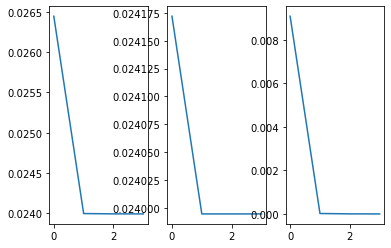

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=3)
ax[0].plot(vae.history.history["loss"])
ax[1].plot(vae.history.history["reconstruction_loss"])
ax[2].plot(vae.history.history["kl_loss"])

In [10]:
test_set=[]
for j in range(batch_len, batch_len*2):
    if j>len(xyz):
        break
    test_set.append([scan(xyz[j],5,5,5)])

dataset = tf.data.Dataset.from_tensor_slices((test_set,))

pred = vae.encoder.predict(dataset)

2023-05-22 12:26:07.809121: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.
2023-05-22 12:26:17.221305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.


1000/1000 [==============================] - 18s 18ms/step


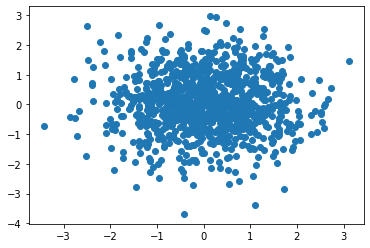

In [11]:
fig,ax=plt.subplots()
ax.scatter(x=[p[0] for p in pred[2]], y=[p[1] for p in pred[2]])
#print(len([p[0] for p in pred[2]]), len([p[1] for p in pred[2]]))

In [19]:
rdata=np.random.normal(0,1, size=(30,2))
pred=decoder.predict(rdata)
x,y,z=deploy(pred)

1/1 [==============================] - 0s 105ms/step


[]

<IPython.core.display.Javascript object>


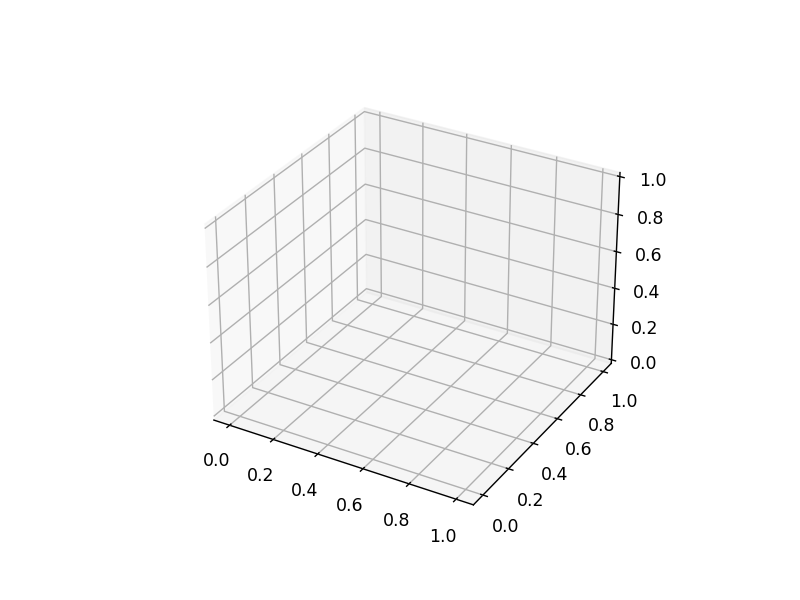

In [16]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)